<a href="https://colab.research.google.com/github/RuTiO2le/nitobe_fs/blob/main/fs_totalling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Parameters

#@markdown 名簿のスプレッドシートのリンク
meibo_path = 'https://docs.google.com/spreadsheets/d/16ttqmxfIhlp8-RP-80hykNIK53i16dcG5xSAPcOb70o/edit#gid=1135885959' #@param {type:"string"}
#@markdown 集計フォームのスプレッドシートのリンク
tot_path = 'https://docs.google.com/spreadsheets/d/1bT5o1MZsCEEsBrOAwrZ0za9LZXnYH2nJziXZaGzAyWM/edit#gid=1712115759' #@param {type:"string"}

#@markdown 集計フォームの「発表の内容やしかたが最も良かったと思うゼミを選んでください。」までの質問項目数(2022年と同じなら変更不要)
offset = 4 #@param {type:"integer"}
#@markdown ゼミ数
n_semi = 7 #@param {type:"integer"}

注1）  
去年のスプレッドシートではコード制作者が最初の行に来ているため集計の際は除外したが、この実装では集計するようになっているため、去年のもので追試する場合は注意  
注2)  
global変数は関数に渡していない  
注3)  
Googleの利用規約変更などでバグが起きた場合は適宜修正  

**あとは以下を実行するだけ** 

 ## Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

!pip install japanize_matplotlib
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pprint
from typing import Dict, List

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=4d9658103b14febbce097bf66f18b131ba398df28712c11a9f55c13fccefa332
  Stored in directory: /root/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize_matplotlib


In [4]:
def confirm_attemdamce(students: List, list_of_form: List) -> None:
    stu_set = set()
    for i, st in enumerate(students):
        if i==0: continue
        stu_set.add(st[0])

    attend_stu_set = set()
    for i, ast in enumerate(list_of_form):
        if i>1: attend_stu_set.add(ast[2])

    absent_stu_set = stu_set - attend_stu_set
    print(f'学生数: {len(stu_set)}, 出席数: {len(attend_stu_set)}, 欠席数：{len(absent_stu_set)}', end='\n\n')

    ccm = max(list(map(len, np.array(students)[:,2])))
    km  = max(list(map(len, np.array(students)[:,3])))
    print('欠席者：', end='\n\n')
    for st in students:
        if st[0] in absent_stu_set:
            exec( "print(f'''{st[0]}　　　　{st[2].replace('　',''):　<%ds}{st[3].replace('　',''):　<%ds}{st[4]}''')" % (ccm+1, km+1) )

In [44]:
def get_semi_dict(semi_list: List) -> Dict:
    eval_selects = {}
    for semi in semi_list:
        exec(f'eval_selects["{semi}"]=[]')
    return eval_selects

def total_vote(list_of_form: List, mode="tot"):
    eval_selects = get_semi_dict(semi_list)
    eval_discripts = eval_selects.copy()

    vote_total = []
    for i,st in enumerate(list_of_form):
        if i<1:
            continue
        bel = st[4]
        vote = st[offset + int(bel[0])]
        vote_total.append(vote)

        snum = int(vote[0])
        eval_selects[vote] += [s[0] for s in st[offset+n_semi + snum*2 - 1].split(', ')]
        eval_discripts[vote].append( st[offset+n_semi + snum*2] )

    if mode=="tot":
        nov_list = []
        for semi in semi_list:
            nov = vote_total.count(semi)
            nov_list.append(nov)
            print(semi, nov)

        print()
        plt.figure(figsize=(9,5), facecolor="w")
        plt.bar(semi_list, nov_list)
        plt.savefig("totaling.png", facecolor="w")

    else:
        return eval_selects

In [63]:
def draw_pie(eval_selects: Dict):
    wed = {'alpha': 0.8, 'edgecolor':'white'}
    sel_count = get_semi_dict(semi_list)
    for k in eval_selects.keys():
        _leg = leg.copy()
        l = eval_selects[k]
        del_idx = []
        for i, alp in enumerate(alps):
            n = l.count(alp)
            if n==0:
                del_idx.append(i)
            else:
                sel_count[k].append(n)
                # _leg[i] += f'({n})'
        
        for i in del_idx[::-1]: del _leg[i]

        plt.figure(figsize=(13,7))
        plt.title(f'{k} 評価項目の割合', fontsize=20)
        plt.pie(sel_count[k], labels=_leg, counterclock=False, startangle=90, wedgeprops=wed)
        plt.savefig(f'{k}.png') # Driveに保存したければパスを書き換える

In [67]:
def write_comments(list_of_form: List) -> None:
    eval_discripts_with_alp = get_semi_dict(semi_list)

    for i,st in enumerate(list_of_form):
        if i<1:
            continue
        bel = st[4]
        vote = st[offset + int(bel[0])]

        snum = int(vote[0])
        alp_l = [s[0] for s in st[offset+n_semi + snum*2 - 1].split(', ')]
        eval_discripts_with_alp[vote].append( f'[{", ".join(alp_l)}]\n{st[offset+n_semi + snum*2]}' )

    for k in eval_selects.keys():
        f = open(f'{k}.txt', 'w') # Driveに保存したければパスを書き換える
        f.write('\n\n'.join( eval_discripts_with_alp[k] ))
        f.close

In [37]:
ss_meibo = gc.open_by_url(meibo_path)
st_meibo = ss_meibo.get_worksheet(0)
students = st_meibo.get_all_values()

ss_form = gc.open_by_url(tot_path)
st_form = ss_form.get_worksheet(0)
list_of_form = st_form.get_all_values()

semi_list = []
for i in range(n_semi):
    idx = list_of_form[0][offset+n_semi + (i+1)*2 - 1].find('の発表')
    semi_list.append(f'{i+1}.{list_of_form[0][offset+n_semi + (i+1)*2 - 1][:idx]}')

## 出力

In [6]:
# 出欠確認
confirm_attemdamce(students, list_of_form)

学生数: 188, 出席数: 153, 欠席数：35

欠席者：

01212190　　　　川村光紀　　　　カワムラコウキ　　　　kawamura.kouki.b2@elms.hokudai.ac.jp
01222039　　　　森友勇人　　　　モリトモハヤト　　　　moritomo.hayato.o0@elms.hokudai.ac.jp
01222097　　　　見城莉生　　　　ケンジョウリオ　　　　kenjo.rio.d3@elms.hokudai.ac.jp
01222132　　　　小黒恩賓　　　　オグロオンビ　　　　　oguro.ombi.w3@elms.hokudai.ac.jp
01222137　　　　栗原優佳　　　　クリハラユウカ　　　　kurihara.yuka.l0@elms.hokudai.ac.jp
01222152　　　　成川航斗　　　　ナリカワコウト　　　　narikawa.koto.h0@elms.hokudai.ac.jp
01222158　　　　牧山皓蔵　　　　マキヤマコウゾウ　　　makiyama.kozo.b6@elms.hokudai.ac.jp
01223025　　　　三田地萌絵　　　ミタチモエ　　　　　　mitachi.moe.u9@elms.hokudai.ac.jp
01224018　　　　小泉貴己　　　　コイズミタカミ　　　　koizumi.takami.n0@elms.hokudai.ac.jp
01224046　　　　山田凱生　　　　ヤマダガイ　　　　　　yamada.gai.s0@elms.hokudai.ac.jp
01224079　　　　辻川哲平　　　　ツジカワテッペイ　　　tsujikawa.teppei.j9@elms.hokudai.ac.jp
01224086　　　　船越谷花　　　　フナコシヤハナ　　　　funakoshiya.hana.e6@elms.hokudai.ac.jp
01225017　　　　坂本優哉　　　　サカモトユウヤ　　　　sakamoto.yuya.v9@elms.hokudai.ac.jp
01225081　　　　三島晴斗　　　　ミシマハルト　　　　　mishima.haruto.s5@elms.hokudai.ac.jp
01225107　　　　備千怜　　　　　ソナエチサト　　　

1.石川裕一ゼミ 20
2.萩野ゼミ 42
3.大友ゼミ 6
4.伊藤ゼミ 7
5.松尾ゼミ 27
6.石川めぐみゼミ 21
7.廣重ゼミ 30



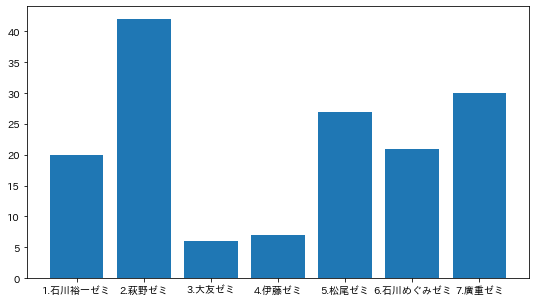

In [28]:
# 集計
total_vote(list_of_form)

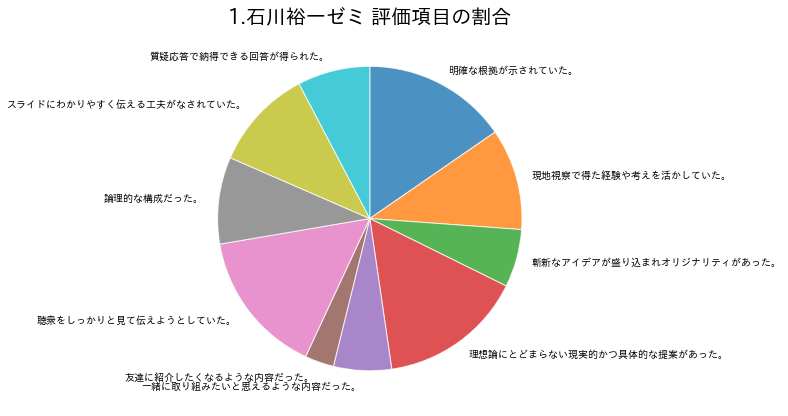

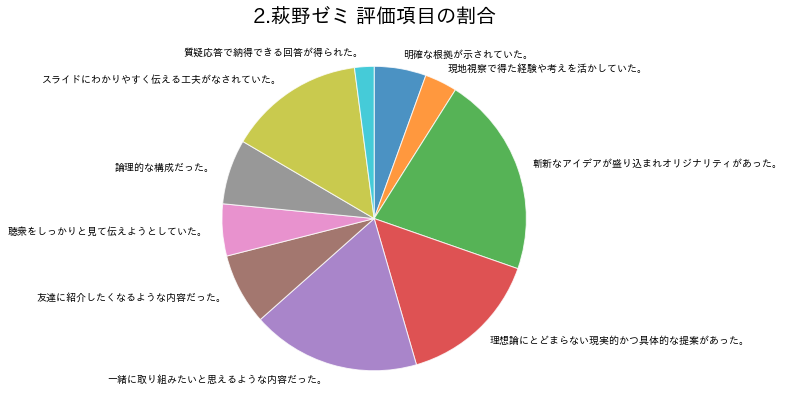

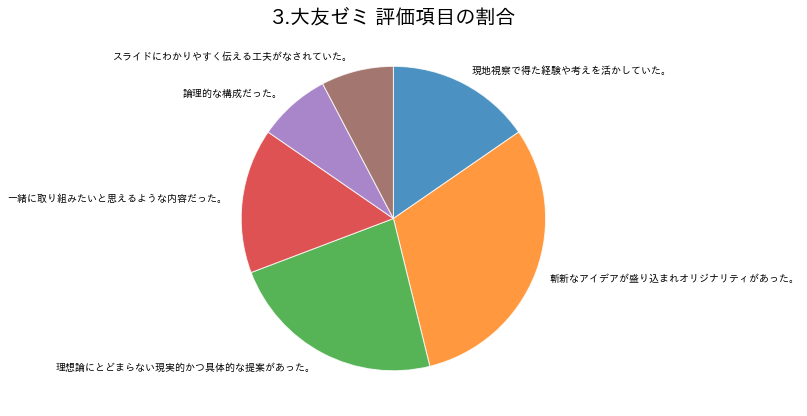

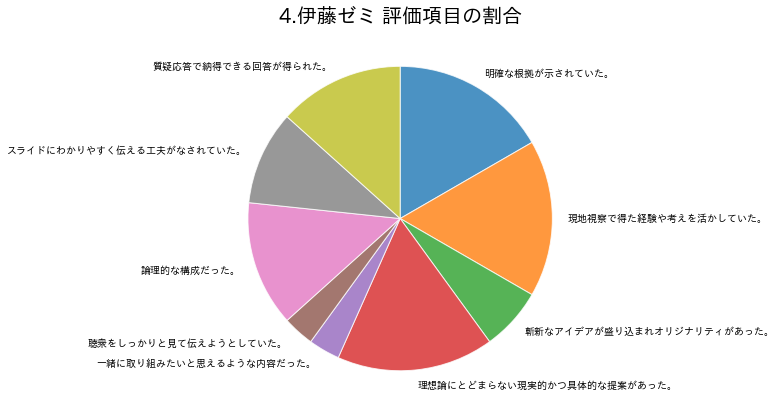

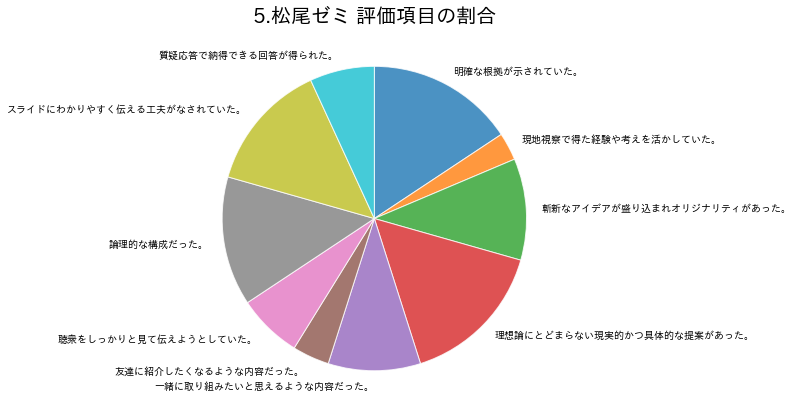

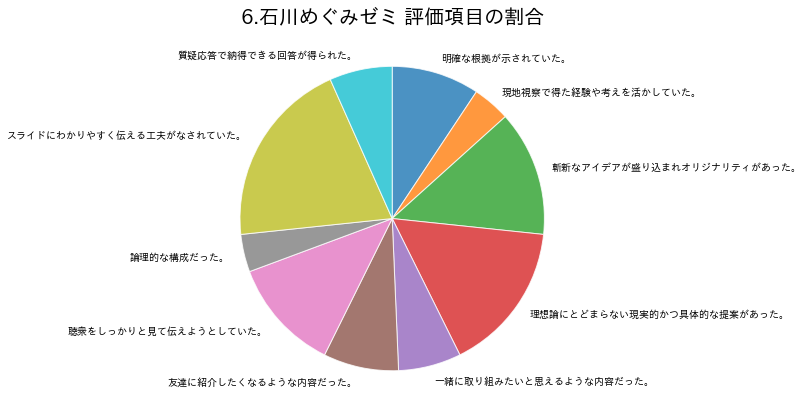

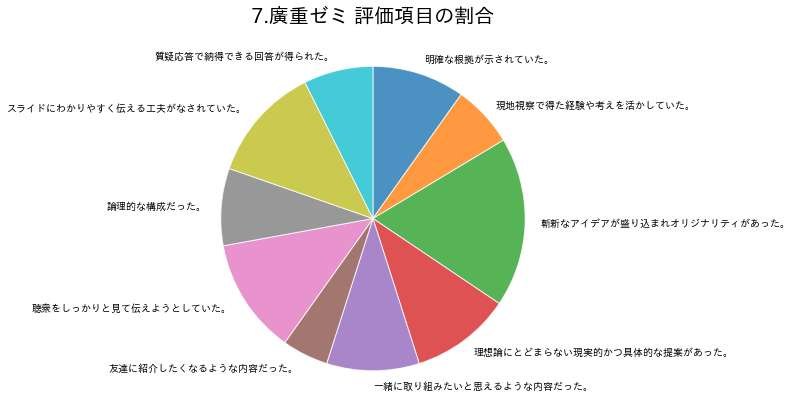

In [64]:
# 円グラフ
alps = ['a', 'b', 'c',
        'd', 'e', 'f',
        'g', 'h', 'i',
        'j'] # 変更があれば適宜変える
leg = ['明確な根拠が示されていた。', '現地視察で得た経験や考えを活かしていた。', '斬新なアイデアが盛り込まれオリジナリティがあった。',
       '理想論にとどまらない現実的かつ具体的な提案があった。', '一緒に取り組みたいと思えるような内容だった。', '友達に紹介したくなるような内容だった。',
       '聴衆をしっかりと見て伝えようとしていた。', '論理的な構成だった。', 'スライドにわかりやすく伝える工夫がなされていた。',
       '質疑応答で納得できる回答が得られた。'] # 変更があれば適宜変える

eval_selects = total_vote(list_of_form, mode="o")
draw_pie(eval_selects)

In [68]:
# コメントを.txtで出力
# 関数内でパスを書き換えれば、ドライブに直接書き出すことも可能
write_comments(list_of_form)